# Kafka + Flink Pipeline Latency Analysis

## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## 2. Load the Data
# Change filename to your local path if needed

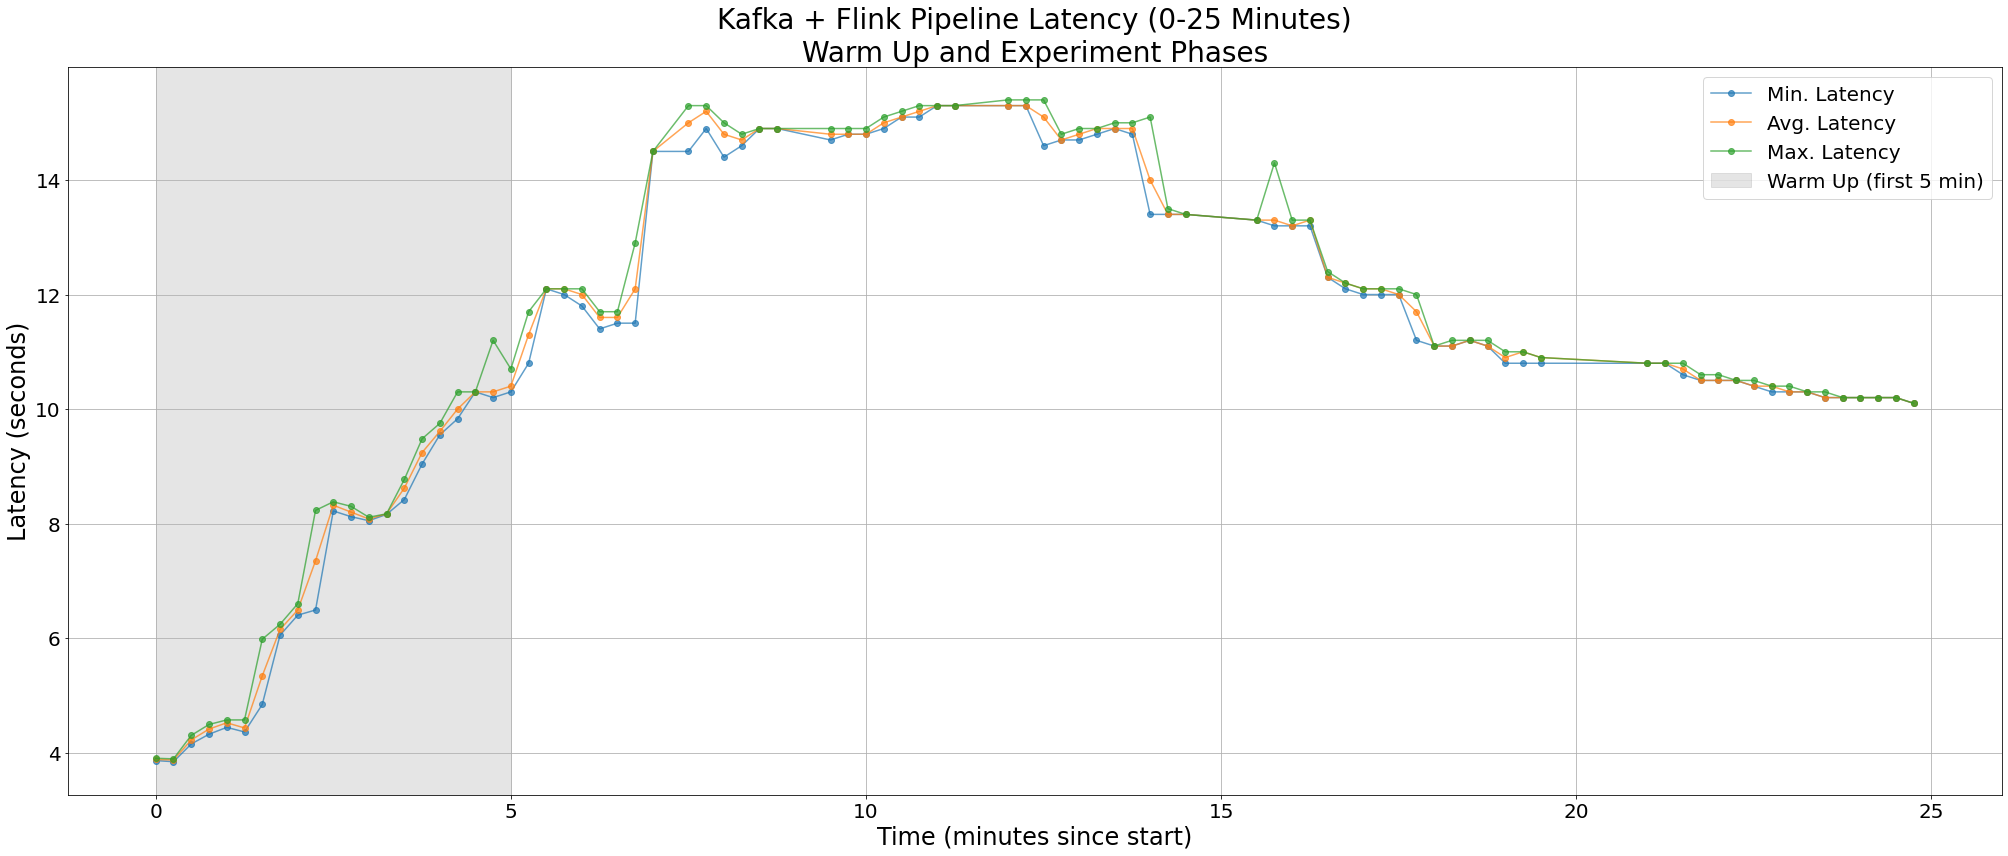

Experiment phase summary statistics:
        Min. Latency  Avg. Latency  Max. Latency
count     67.000000     67.000000     67.000000
mean      12.550746     12.646269     12.761194
std        1.896598      1.914643      1.951375
min       10.100000     10.100000     10.100000
25%       10.800000     10.850000     10.850000
50%       12.000000     12.100000     12.100000
75%       14.700000     14.800000     14.900000
max       15.300000     15.300000     15.400000 

Experiment phase IQR (25%, 75% quantiles):
       Min. Latency  Avg. Latency  Max. Latency
0.25          10.8         10.85         10.85
0.75          14.7         14.80         14.90 

Max latency row (spike):
 Time             2025-07-25 10:10:30
Min. Latency                    15.3
Avg. Latency                    15.3
Max. Latency                    15.4
TimeDelta_sec                  720.0
TimeDelta_min                   12.0
Phase                     experiment
Name: 43, dtype: object 

Number of outliers (avg. laten

In [5]:
filename = "Pipeline Latency (flink-job + prink-job) -data-as-joinbyfield-2025-07-25 10_31_42.csv"
df = pd.read_csv(filename)

## 3. Prepare the Data
# Convert Time to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Convert latency columns to float (strip " s")
for col in ['Min. Latency', 'Avg. Latency', 'Max. Latency']:
    df[col] = df[col].str.replace(' s', '').astype(float)

# Compute elapsed time since start
df['TimeDelta_sec'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()
df['TimeDelta_min'] = df['TimeDelta_sec'] / 60

# Annotate phase (first 5 min = warm up, next 20 min = experiment)
df['Phase'] = df['TimeDelta_min'].apply(lambda x: 'warm up' if x < 5 else 'experiment')

# Limit data to first 25 minutes
df_limited = df[df['TimeDelta_min'] < 25].copy()
df_experiment = df_limited[df_limited['Phase'] == 'experiment']

## 4. Plot Latencies with Warm-Up Annotation
plt.figure(figsize=(28, 12))
plt.plot(df_limited['TimeDelta_min'], df_limited['Min. Latency'], label='Min. Latency', marker='o', alpha=0.7)
plt.plot(df_limited['TimeDelta_min'], df_limited['Avg. Latency'], label='Avg. Latency', marker='o', alpha=0.7)
plt.plot(df_limited['TimeDelta_min'], df_limited['Max. Latency'], label='Max. Latency', marker='o', alpha=0.7)
plt.axvspan(0, 5, color='grey', alpha=0.2, label='Warm Up (first 5 min)')
plt.xlabel('Time (minutes since start)', fontsize=24)
plt.ylabel('Latency (seconds)', fontsize=24)
plt.title('Kafka + Flink Pipeline Latency (0-25 Minutes)\nWarm Up and Experiment Phases', fontsize=28)
plt.legend(fontsize=20)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

## 5. Performance Metrics (Experiment Phase Only)
experiment_stats = df_experiment[['Min. Latency', 'Avg. Latency', 'Max. Latency']].describe()
experiment_iqr = df_experiment[['Min. Latency', 'Avg. Latency', 'Max. Latency']].quantile([0.25, 0.75])
max_latency_row = df_experiment.loc[df_experiment['Max. Latency'].idxmax()]
avg_mean = df_experiment['Avg. Latency'].mean()
avg_std = df_experiment['Avg. Latency'].std()
outlier_count = (df_experiment['Avg. Latency'] > (avg_mean + 2*avg_std)).sum()

print("Experiment phase summary statistics:\n", experiment_stats, "\n")
print("Experiment phase IQR (25%, 75% quantiles):\n", experiment_iqr, "\n")
print("Max latency row (spike):\n", max_latency_row, "\n")
print("Number of outliers (avg. latency > mean+2*std):", outlier_count)

# --- Privacy Parameter Analysis: k-Anonymity and l-Diversity ---


---- k-Anonymity metrics (experiment phase) ----
count    80.00000
mean     17.26250
std       4.17571
min       5.00000
25%      14.00000
50%      19.00000
75%      21.00000
max      21.00000
Name: Observed k, dtype: float64
Number of times below defined k: 0

---- l-Diversity metrics (experiment phase) ----
count    80.000000
mean      2.925000
std       0.265053
min       2.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       3.000000
Name: Observed l, dtype: float64
Number of times below defined l: 6


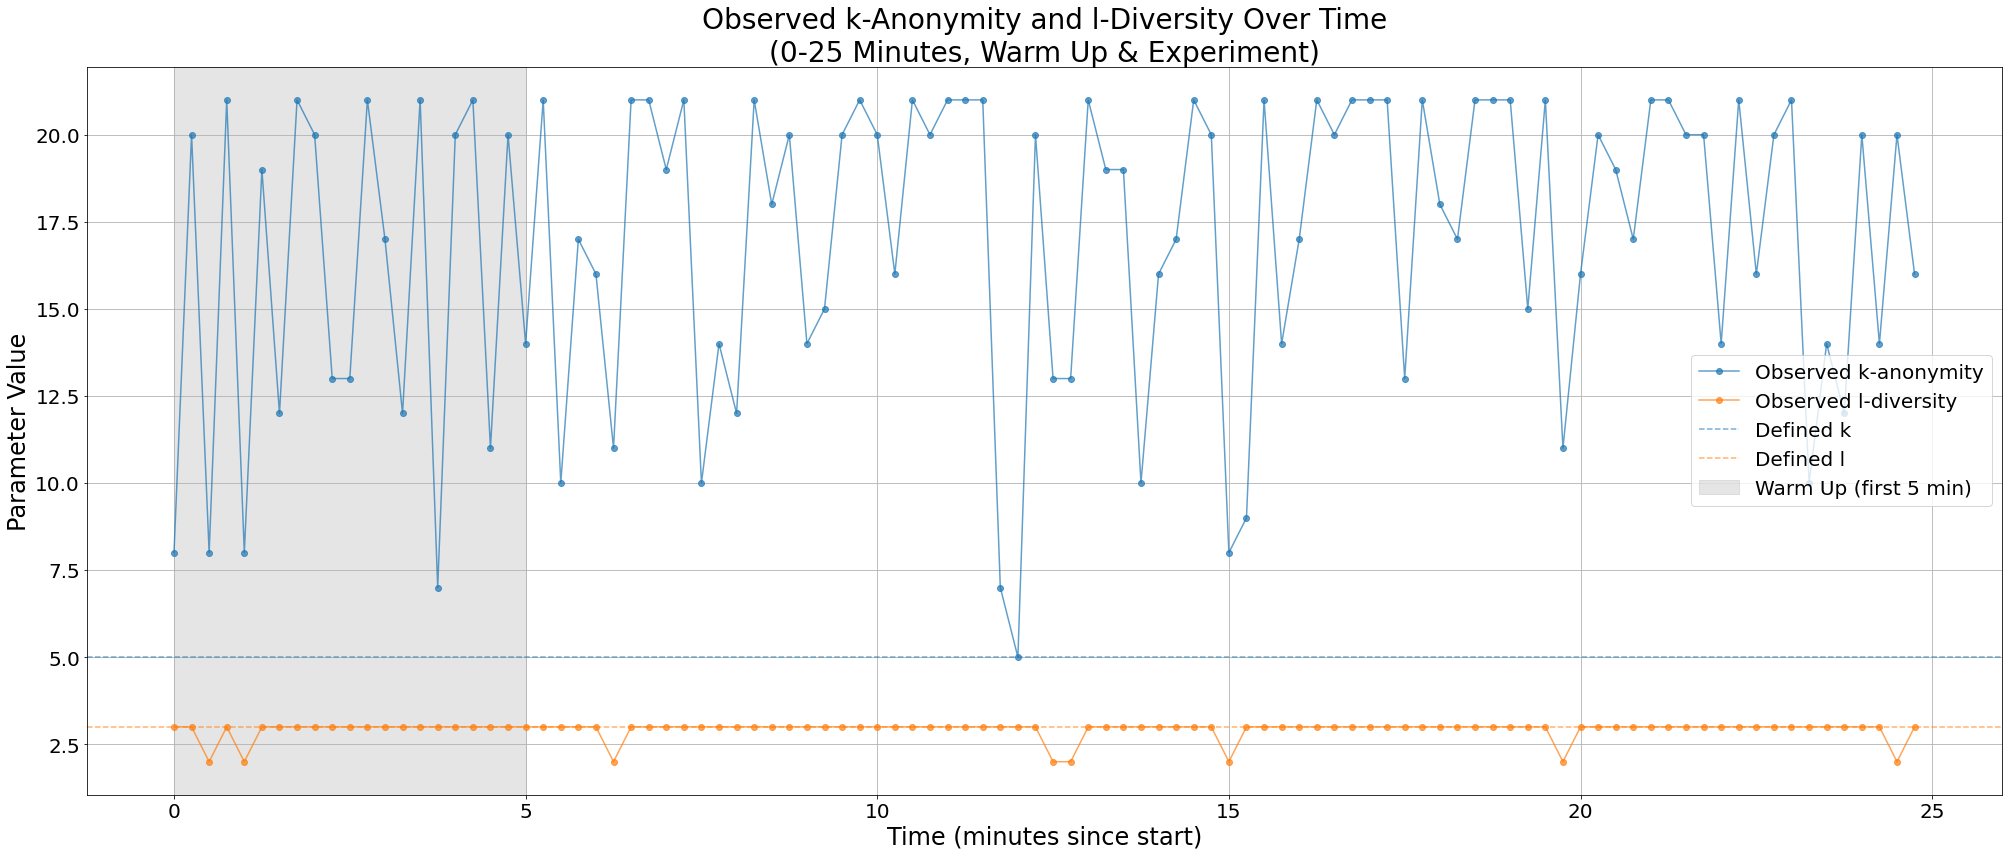

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load k-anonymity and l-diversity data
k_file = "k-anonymity-data-as-joinbyfield-2025-07-25 10_48_55.csv"
l_file = "l-diversity-data-as-joinbyfield-2025-07-25 10_49_10.csv"
df_k = pd.read_csv(k_file)
df_l = pd.read_csv(l_file)

# 2. Parse Time and calculate elapsed minutes
for df in [df_k, df_l]:
    df['Time'] = pd.to_datetime(df['Time'])
    df['TimeDelta_sec'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()
    df['TimeDelta_min'] = df['TimeDelta_sec'] / 60
    df['Phase'] = df['TimeDelta_min'].apply(lambda x: 'warm up' if x < 5 else 'experiment')

# 3. Limit to first 25 minutes and split by phase
df_k_lim = df_k[df_k['TimeDelta_min'] < 25].copy()
df_l_lim = df_l[df_l['TimeDelta_min'] < 25].copy()
df_k_exp = df_k_lim[df_k_lim['Phase'] == 'experiment']
df_l_exp = df_l_lim[df_l_lim['Phase'] == 'experiment']

# 4. Key metrics for experiment phase
k_stats = df_k_exp['Observed k'].describe()
l_stats = df_l_exp['Observed l'].describe()
k_below_defined = (df_k_exp['Observed k'] < df_k_exp['Defined k']).sum()
l_below_defined = (df_l_exp['Observed l'] < df_l_exp['Defined l']).sum()

print("---- k-Anonymity metrics (experiment phase) ----")
print(k_stats)
print(f"Number of times below defined k: {k_below_defined}")

print("\n---- l-Diversity metrics (experiment phase) ----")
print(l_stats)
print(f"Number of times below defined l: {l_below_defined}")

# 5. Plot observed k and l over time
plt.figure(figsize=(28, 12))
plt.plot(df_k_lim['TimeDelta_min'], df_k_lim['Observed k'], label='Observed k-anonymity', marker='o', alpha=0.7)
plt.plot(df_l_lim['TimeDelta_min'], df_l_lim['Observed l'], label='Observed l-diversity', marker='o', alpha=0.7)
plt.axhline(df_k_lim['Defined k'].iloc[0], color='tab:blue', linestyle='--', alpha=0.6, label='Defined k')
plt.axhline(df_l_lim['Defined l'].iloc[0], color='tab:orange', linestyle='--', alpha=0.6, label='Defined l')
plt.axvspan(0, 5, color='grey', alpha=0.2, label='Warm Up (first 5 min)')
plt.xlabel('Time (minutes since start)', fontsize=24)
plt.ylabel('Parameter Value', fontsize=24)
plt.title('Observed k-Anonymity and l-Diversity Over Time\n(0-25 Minutes, Warm Up & Experiment)', fontsize=28)
plt.legend(fontsize=20)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

# Overhead Comparison

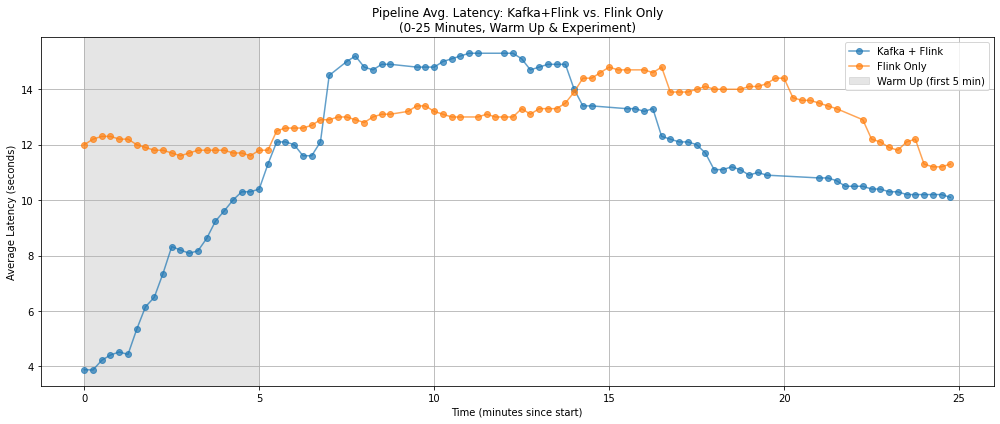

=== Kafka + Flink (experiment phase) ===
mean     12.646269
std       1.914643
min      10.100000
25%      10.850000
50%      12.100000
75%      14.800000
max      15.300000
count    67.000000
Name: Avg. Latency, dtype: float64

=== Flink Only (experiment phase) ===
mean     13.248649
std       0.908143
min      11.200000
25%      12.900000
50%      13.200000
75%      13.975000
max      14.800000
count    74.000000
Name: Avg. Latency, dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Both Datasets ---
file_kafka_flink = "Pipeline Latency (flink-job + prink-job) -data-as-joinbyfield-2025-07-25 10_31_42.csv"
file_flink_only  = "Pipeline Latency (flink-job) -data-as-joinbyfield-2025-07-25 13_00_58.csv"
df_kafka_flink = pd.read_csv(file_kafka_flink)
df_flink_only  = pd.read_csv(file_flink_only)

# --- 2. Prepare Data Function ---
def prep_latency_df(df):
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Min. Latency', 'Avg. Latency', 'Max. Latency']:
        df[col] = df[col].str.replace(' s', '').astype(float)
    df['TimeDelta_sec'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()
    df['TimeDelta_min'] = df['TimeDelta_sec'] / 60
    df['Phase'] = df['TimeDelta_min'].apply(lambda x: 'warm up' if x < 5 else 'experiment')
    return df[df['TimeDelta_min'] < 25].copy()

df_kf_lim = prep_latency_df(df_kafka_flink)
df_fl_lim = prep_latency_df(df_flink_only)

# --- 3. Plot Side-by-Side: Avg. Latency ---
plt.figure(figsize=(14, 6))
plt.plot(df_kf_lim['TimeDelta_min'], df_kf_lim['Avg. Latency'], label='Kafka + Flink', marker='o', alpha=0.7)
plt.plot(df_fl_lim['TimeDelta_min'], df_fl_lim['Avg. Latency'], label='Flink Only', marker='o', alpha=0.7)
plt.axvspan(0, 5, color='grey', alpha=0.2, label='Warm Up (first 5 min)')
plt.xlabel('Time (minutes since start)')
plt.ylabel('Average Latency (seconds)')
plt.title('Pipeline Avg. Latency: Kafka+Flink vs. Flink Only\n(0-25 Minutes, Warm Up & Experiment)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4. Print Side-by-Side Summary Statistics ---
def latency_stats(df):
    stats = df[df['Phase']=='experiment']['Avg. Latency'].describe()
    return stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'count']]

print("=== Kafka + Flink (experiment phase) ===")
print(latency_stats(df_kf_lim))
print("\n=== Flink Only (experiment phase) ===")
print(latency_stats(df_fl_lim))